<a href="https://colab.research.google.com/github/yooinsun/AI/blob/main/Leaf_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense, Conv2D, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
import cv2
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data overview

In [4]:
#구글 drive 에서 파일 가져오기

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train/train.tsv', sep='\t' , names=['file_name','plant_label','disease_label'] )
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/test/test.tsv', names=['file_name'])
print(train.shape)
print(test.shape)

(16000, 3)
(3997, 1)


In [5]:
# plant_label 과 disease_label 을 class_label 로 변경하기
def get_class_label(x):

    if x['plant_label'] == 3 and x['disease_label'] == 5:
        return 0
    if x['plant_label'] == 3 and x['disease_label'] == 20:
        return 1
    if x['plant_label'] == 4 and x['disease_label'] == 2:
        return 2
    if x['plant_label'] == 4 and x['disease_label'] == 7:
        return 3
    if x['plant_label'] == 4 and x['disease_label'] == 11:
        return 4
    if x['plant_label'] == 5 and x['disease_label'] == 8:
        return 5
    if x['plant_label'] == 7 and x['disease_label'] == 1:
        return 6
    if x['plant_label'] == 7 and x['disease_label'] == 20:
        return 7
    if x['plant_label'] == 8 and x['disease_label'] == 6:
        return 8
    if x['plant_label'] == 8 and x['disease_label'] == 9:
        return 9
    if x['plant_label'] == 10 and x['disease_label'] == 20:
        return 10
    if x['plant_label'] == 11 and x['disease_label'] == 14:
        return 11
    if x['plant_label'] == 13 and x['disease_label'] == 1:
        return 12
    if x['plant_label'] == 13 and x['disease_label'] == 6:
        return 13
    if x['plant_label'] == 13 and x['disease_label'] == 9:
        return 14
    if x['plant_label'] == 13 and x['disease_label'] == 15:
        return 15
    if x['plant_label'] == 13 and x['disease_label'] == 16:
        return 16
    if x['plant_label'] == 13 and x['disease_label'] == 17:
        return 17
    if x['plant_label'] == 13 and x['disease_label'] == 18:
        return 18
    if x['plant_label'] == 13 and x['disease_label'] == 20:
        return 19

train['class_label'] = train.apply(lambda x : get_class_label(x), axis= 1)

In [ ]:
# train 데이터프레임에 file_path 주소 추가하기
train['file_path'] = train['file_name'].map(lambda x : '/content/drive/My Drive/Colab Notebooks/data/train/' + x )

In [ ]:
# train 과 validation 데이터 나누기
train, val = train_test_split(train, test_size=0.2)
print(len(train), '훈련 샘플')
print(len(val), '검증 샘플')

## Data Exploration

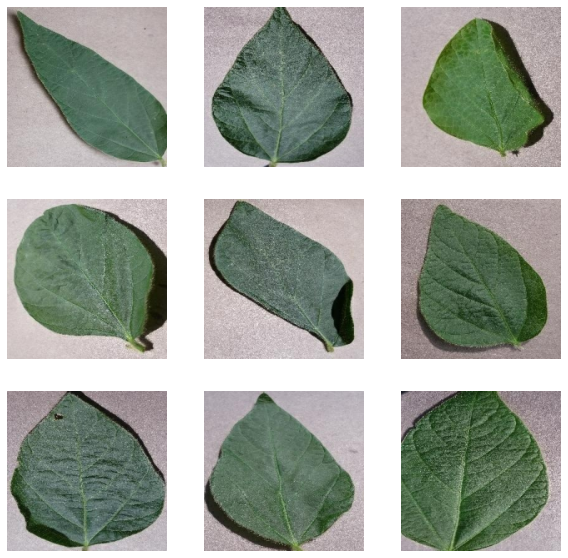

In [49]:
import cv2
import numpy as np

plt.figure(figsize=(10, 10))

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = tf.io.read_file(sorted(train['file_path'])[i])
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [224, 224])
  plt.imshow(img.numpy().astype("uint8"))
  plt.axis("off")

## Training the model

In [7]:
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

In [8]:
train['class_label'] = train['class_label'].astype(str)
val['class_label'] = val['class_label'].astype(str)

In [9]:
# 데이터 로딩하기
IMAGE_SHAPE = (224, 224)
image_generator =ImageDataGenerator(rescale=1./255) # 모든 텐서프로 허브의 이미지 모듈들은 0과 1 사이의 상수를 입력해야한다. 따라서,rescale 인자를 사용한다.
train_image_data =image_generator.flow_from_dataframe(dataframe=train, x_col="file_path", y_col="class_label", class_mode="categorical", target_size=IMAGE_SHAPE)
val_image_data =image_generator.flow_from_dataframe(dataframe=val, x_col="file_path", y_col="class_label", class_mode="categorical", target_size=IMAGE_SHAPE)

Found 12800 validated image filenames belonging to 20 classes.


In [10]:
for image_batch, label_batch in train_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 20)


#### 베이스모델 만들기

In [11]:
# 텐서플로 허브는 맨 위 분류층이 없어도 모델을 분배 시킬 수 있다. 이는 전이학습을 쉽게 할 수 있게 만든다.


feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [12]:
# 특성추출기를 만든다.
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [13]:
# 각각의 이미지마다 길이가 1280인 벡터가 반환된다.

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [14]:
# 훈련 모델을 컴파일하고 훈련시키기 전에 컨볼루션 베이스 모델을 고정 시켜야한다.
# 고정(layer.trainable = False를 설정하여)하면 훈련 중 지정된 층의 가중치가 업데이트되지 않는다.

feature_extractor_layer.trainable = False

In [15]:
# tf.keras.Sequential모델을 사용하여 특징 추출기와 새로운 분류 계층을 쌓는다.

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(20 , activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
predictions = model(image_batch)

In [17]:
predictions.shape

TensorShape([32, 20])

In [18]:
# compile 사용해서 학습 과정 환경설정하기

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

## Making prediction

In [26]:
# 모델 학습시키기
steps_per_epoch = np.ceil(train_image_data.samples/train_image_data.batch_size)

history = model.fit(train_image_data, epochs=10,
                              steps_per_epoch=steps_per_epoch,
                              validation_data = val_image_data)


Epoch 1/10
400/400 [==============================] - 55s 138ms/step - loss: 0.1791 - acc: 0.9486 - val_loss: 0.2071 - val_acc: 0.9347
Epoch 2/10
400/400 [==============================] - 53s 134ms/step - loss: 0.1416 - acc: 0.9601 - val_loss: 0.1863 - val_acc: 0.9459
Epoch 3/10
400/400 [==============================] - 53s 132ms/step - loss: 0.1196 - acc: 0.9671 - val_loss: 0.1784 - val_acc: 0.9466
Epoch 4/10
400/400 [==============================] - 52s 130ms/step - loss: 0.1022 - acc: 0.9723 - val_loss: 0.1799 - val_acc: 0.9444
Epoch 5/10
400/400 [==============================] - 53s 132ms/step - loss: 0.0885 - acc: 0.9770 - val_loss: 0.1757 - val_acc: 0.9478
Epoch 6/10
400/400 [==============================] - 52s 130ms/step - loss: 0.0776 - acc: 0.9803 - val_loss: 0.1599 - val_acc: 0.9531
Epoch 7/10
400/400 [==============================] - 52s 130ms/step - loss: 0.0685 - acc: 0.9841 - val_loss: 0.1581 - val_acc: 0.9528
Epoch 8/10
400/400 [==============================] - 5

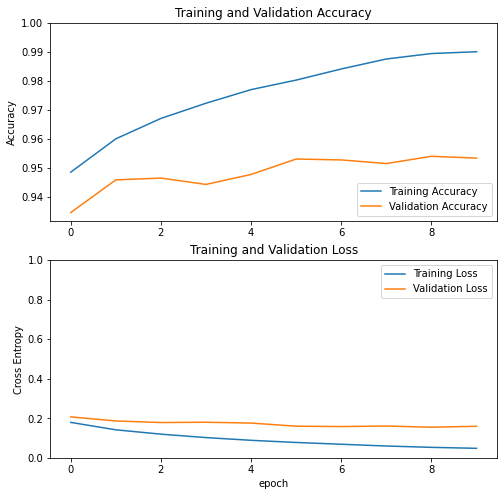

In [27]:
# 예측결과 시각화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# 모델 내보내기

import time
t = time.time()

export_path = "/content/drive/My Drive/Colab Notebooks/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/1604668309/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/1604668309/assets


'/content/drive/My Drive/Colab Notebooks/1604668309'